In [1]:
import scanpy as sc
import numpy as np
import pandas as pd
import anndata 
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

import seaborn as sns
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors

# Para pseudotime con PAGA (Scanpy tiene métodos similares a Monocle3)
import scanpy.external as sce

import palantir
import palantir.utils as utils
from sklearn.decomposition import PCA
from palantir.presults import compute_gene_trends

from pygam import GAM, s
from statsmodels.stats.multitest import multipletests
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist, squareform
import seaborn as sns

from tqdm import tqdm
from sklearn.preprocessing import StandardScaler

SEED = 42
sc.settings.seed = SEED
np.random.seed(SEED)
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)

# The environment is in conda bash in Windows

In [2]:
import loompy
# 1. Abrir archivo loom
ds = loompy.connect("/lustre1/project/stg_00135/Cecilia/Data/SCENIC/all.both.patients_pySCENIC.loom", mode='r', validate=False)

# 2. Extraer matriz genes x células
X = ds[:, :]

# 3. Extraer metadatos de genes (rows)
var = pd.DataFrame({'Gene': ds.ra['Gene']})

# 4. Extraer metadatos de células (columns)
obs = pd.DataFrame({key: ds.ca[key] for key in ds.ca.keys()})

# 5. Guardar regulones (tuplas) en uns
regulons_tuples = ds.ra['Regulons']

ds.close()

# Para obs y var:
obs.index = obs.index.astype(str)
var.index = var.index.astype(str)
# 6. Crear objeto AnnData
adata = anndata.AnnData(X=X.T, var=var, obs=obs)

# 7. Guardar regulones en adata.uns
adata.uns['Regulons_tuples'] = regulons_tuples

# 8. Columnas complejas para mover a .obsm
cols_complex = ['Clusterings', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC']

# 9. Mover columnas complejas de obs a obsm
for col in cols_complex:
    adata.obsm[col] = np.array(adata.obs[col].tolist(), dtype=object)  # FORMA CORRECTA
    del adata.obs[col]

# 10. Verificación
adata


AnnData object with n_obs × n_vars = 72733 × 26156
    obs: 'AvgDistanceToRef', 'CellID', 'RNA_MERGED_clusters', 'nCount_RNA', 'nGene', 'nUMI', 'percent.mito', 'predicted.celltype.l1', 'predicted.celltype.l2', 'subsample'
    var: 'Gene'
    uns: 'Regulons_tuples'
    obsm: 'Clusterings', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC'

In [3]:
adata.obs.set_index('CellID', inplace=True)
adata.var.set_index('Gene', inplace=True)

# Segmented cells from l1

In [4]:
cd8_adata = adata[adata.obs['predicted.celltype.l1'] == "CD8 T"].copy()

In [5]:
cd8_adata

AnnData object with n_obs × n_vars = 15019 × 26156
    obs: 'AvgDistanceToRef', 'RNA_MERGED_clusters', 'nCount_RNA', 'nGene', 'nUMI', 'percent.mito', 'predicted.celltype.l1', 'predicted.celltype.l2', 'subsample'
    uns: 'Regulons_tuples'
    obsm: 'Clusterings', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC'

# Select the patient

In [6]:
# Para el paciente P116RS
adata_p116 = cd8_adata[cd8_adata.obs["subsample"].str.contains("P116RS")].copy()

In [7]:
adata_p116

AnnData object with n_obs × n_vars = 8491 × 26156
    obs: 'AvgDistanceToRef', 'RNA_MERGED_clusters', 'nCount_RNA', 'nGene', 'nUMI', 'percent.mito', 'predicted.celltype.l1', 'predicted.celltype.l2', 'subsample'
    uns: 'Regulons_tuples'
    obsm: 'Clusterings', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC'

In [8]:
# check if CD14 gene is in var
if "CD14" in adata_p116.var_names:
    # keep the cells that do not express CD14
    adata_p116 = adata_p116[adata_p116[:, "CD14"].X.toarray().flatten() == 0, :].copy()
else:
    print("El gen CD14 no está en adata_p116.var_names")


In [9]:
# check if CD14 gene is in var
if "CD4" in adata_p116.var_names:
    # keep the cells that do not express CD14
    adata_p116 = adata_p116[adata_p116[:, "CD4"].X.toarray().flatten() == 0, :].copy()
else:
    print("El gen CD4 no está en adata_p116.var_names")

In [10]:
adata_p116 = adata_p116[adata_p116.obs["predicted.celltype.l2"] != "CD14 Mono"].copy()
adata_p123 = adata_p116[adata_p116.obs["predicted.celltype.l2"] != "CD4 TCM"].copy()
adata_p116.obs["predicted.celltype.l2"].value_counts()

predicted.celltype.l2
CD8 TEM              6977
CD8 Naive             789
CD8 TCM               191
CD8 Proliferating      19
dnT                     3
CD4 TEM                 2
CD4 Naive               2
NK                      1
NK Proliferating        1
CD4 TCM                 1
Name: count, dtype: int64

In [11]:
adata_p116 = adata_p116[adata_p116.obs["percent.mito"] <= 5].copy()

<Axes: >

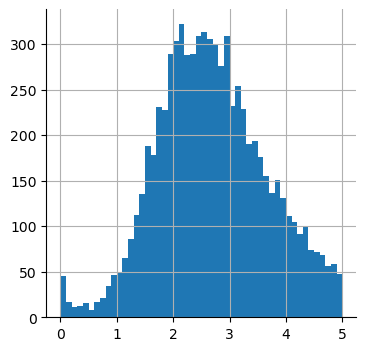

In [12]:
adata_p116.obs["percent.mito"].hist(bins=50)

In [13]:
sc.pp.filter_genes(adata_p116, min_cells=3)

filtered out 8069 genes that are detected in less than 3 cells


In [14]:
# Normalizing to median total counts
sc.pp.normalize_total(adata_p116)
# Logarithmize the data
sc.pp.log1p(adata_p116)

normalizing counts per cell
    finished (0:00:00)


In [15]:
sc.pp.highly_variable_genes(adata_p116, flavor="seurat", n_top_genes=1500)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


In [16]:
sc.pp.pca(adata_p116, n_comps=50)

computing PCA
    with n_comps=50
    finished (0:00:01)


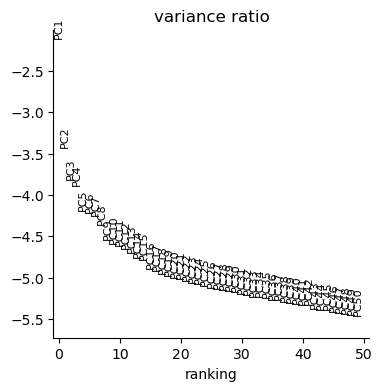

In [17]:
sc.pl.pca_variance_ratio(adata_p116, n_pcs=50, log=True)

In [18]:
sc.pp.neighbors(adata_p116)
sc.tl.umap(adata_p116)

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:04)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:14)


In [19]:
adata_p116

AnnData object with n_obs × n_vars = 7435 × 18087
    obs: 'AvgDistanceToRef', 'RNA_MERGED_clusters', 'nCount_RNA', 'nGene', 'nUMI', 'percent.mito', 'predicted.celltype.l1', 'predicted.celltype.l2', 'subsample'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'Regulons_tuples', 'log1p', 'hvg', 'pca', 'neighbors', 'umap'
    obsm: 'Clusterings', 'Embedding', 'Embeddings_X', 'Embeddings_Y', 'RegulonsAUC', 'X_pca', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

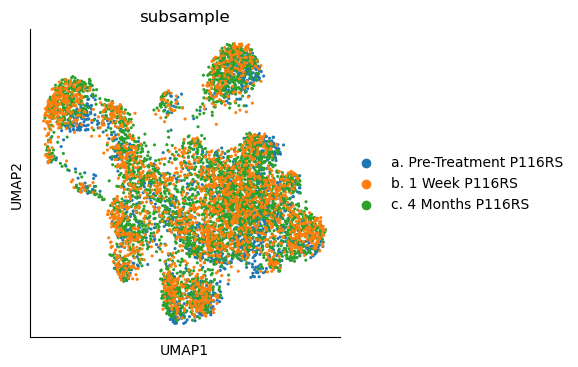

In [20]:
sc.pl.umap(
    adata_p116,
    color="subsample",
    # Setting a smaller point size to get prevent overlap
    size=20,
)

running Leiden clustering


/tmp/ipykernel_3723587/700159212.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata_p116, resolution = 1.0)


    finished: found 14 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


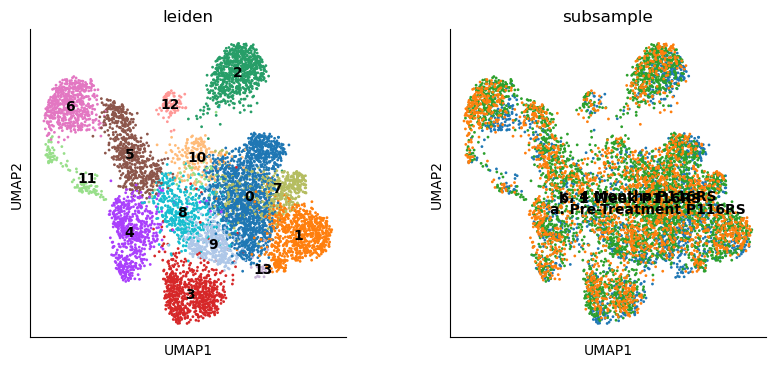

In [21]:
sc.tl.leiden(adata_p116, resolution = 1.0)
sc.pl.umap(adata_p116, color=["leiden", "subsample"], legend_loc="on data")

In [22]:
for res in [0.02, 0.5, 0.8]:
    sc.tl.leiden(adata_p116, resolution=res, key_added=f"leiden_res_{res:.2f}")

running Leiden clustering
    finished: found 1 clusters and added
    'leiden_res_0.02', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 9 clusters and added
    'leiden_res_0.50', the cluster labels (adata.obs, categorical) (0:00:00)
running Leiden clustering
    finished: found 11 clusters and added
    'leiden_res_0.80', the cluster labels (adata.obs, categorical) (0:00:00)


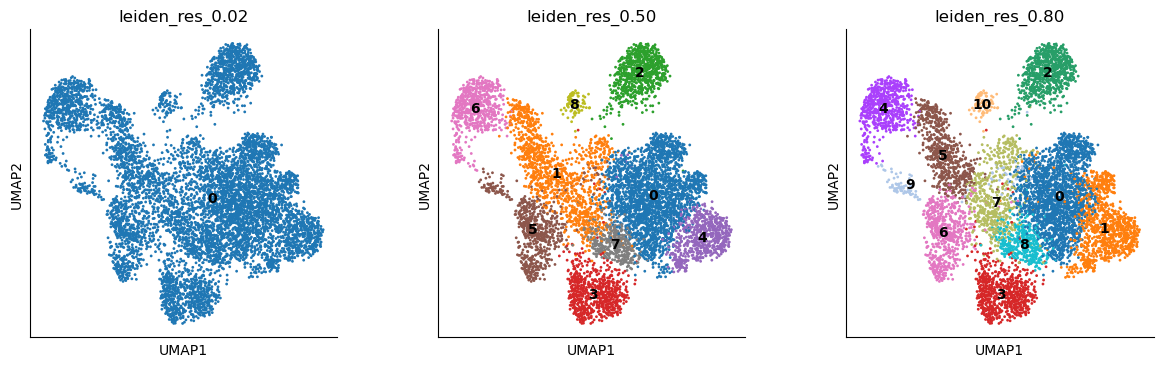

In [23]:
sc.pl.umap(
    adata_p116,
    color=["leiden_res_0.02", "leiden_res_0.50", "leiden_res_0.80"],
    legend_loc="on data",
)

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:09)


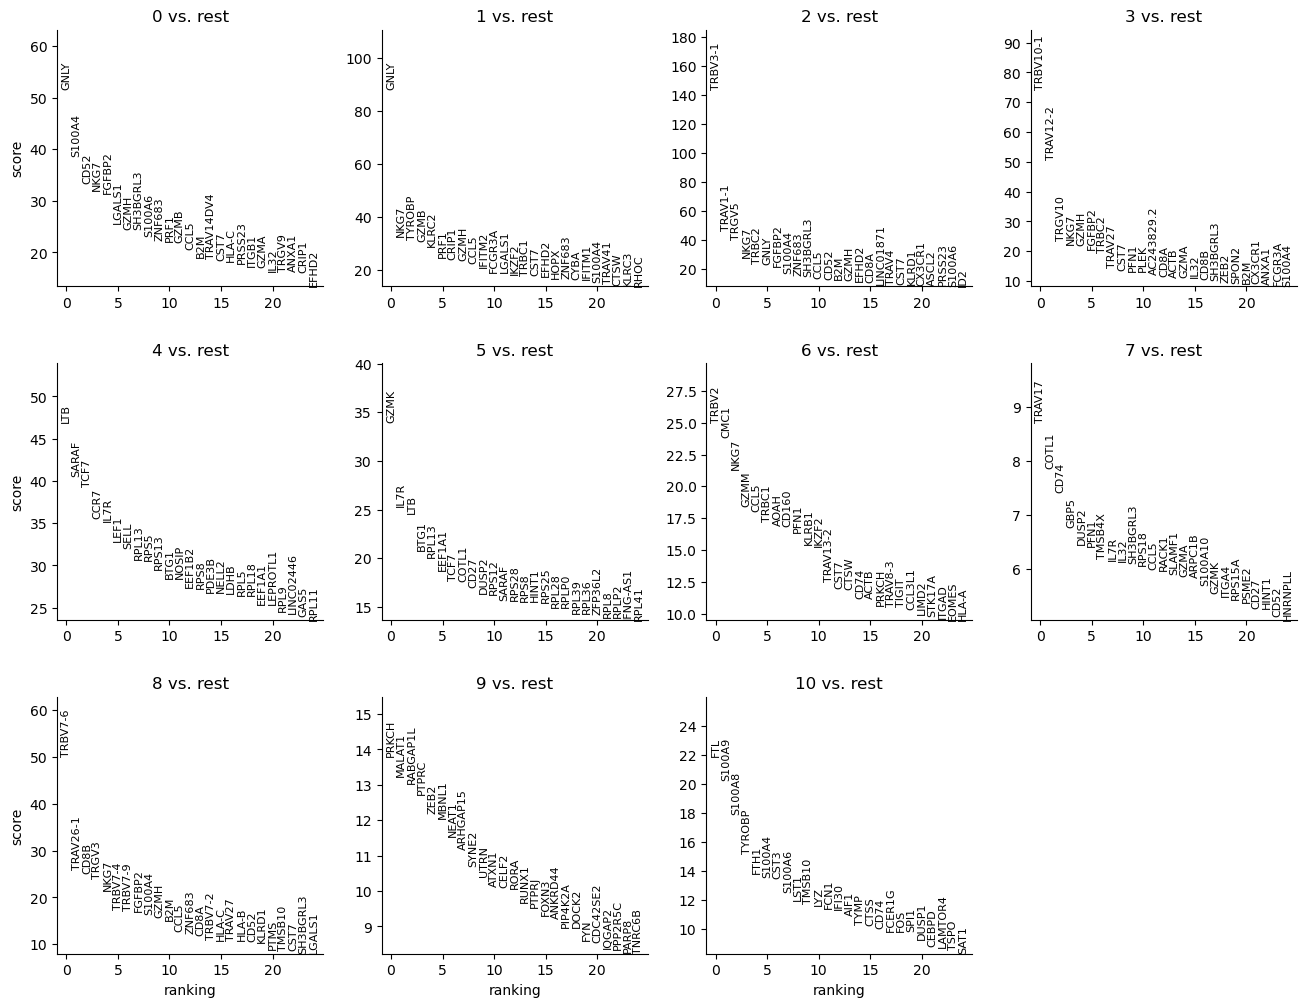

In [24]:
sc.tl.rank_genes_groups(adata_p116, "leiden_res_0.80", method="t-test")
sc.pl.rank_genes_groups(adata_p116, n_genes=25, sharey=False)

In [25]:
sc.tl.rank_genes_groups(adata_p116, groupby="leiden_res_0.80", method="wilcoxon")

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:13)


    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden_res_0.80']`


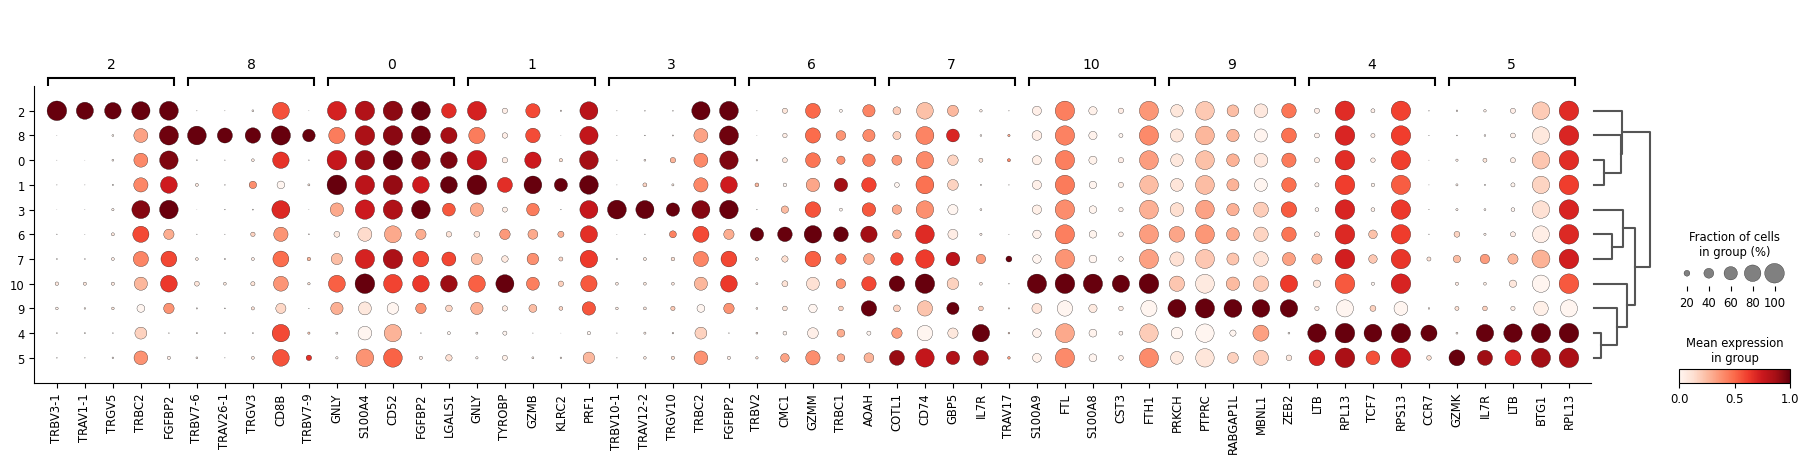

In [26]:
sc.pl.rank_genes_groups_dotplot(adata_p116, groupby="leiden_res_0.80", standard_scale="var", n_genes=5)

In [27]:
sc.get.rank_genes_groups_df(adata_p116, group="5").head(30)

,names,scores,logfoldchanges,pvals,pvals_adj
0,GZMK,29.408310,4.713688,4.299868e-190,1.944293e-186
1,IL7R,23.708456,3.020902,2.949779e-124,5.928073e-121
2,LTB,23.458315,2.608289,1.087324e-121,1.966642e-118
3,BTG1,19.103060,0.962254,2.381170e-81,2.871215e-78
4,RPL13,18.169390,0.465129,9.019454e-74,8.156743e-71
5,TCF7,17.060324,1.847817,2.929313e-65,2.077366e-62
6,COTL1,16.848604,1.526977,1.074216e-63,7.196053e-61
7,EEF1A1,16.836975,0.384690,1.307513e-63,8.446064e-61
8,CD27,15.923465,2.545021,4.355713e-57,2.716613e-54
9,DUSP2,15.814200,2.228158,2.483442e-56,1.497267e-53


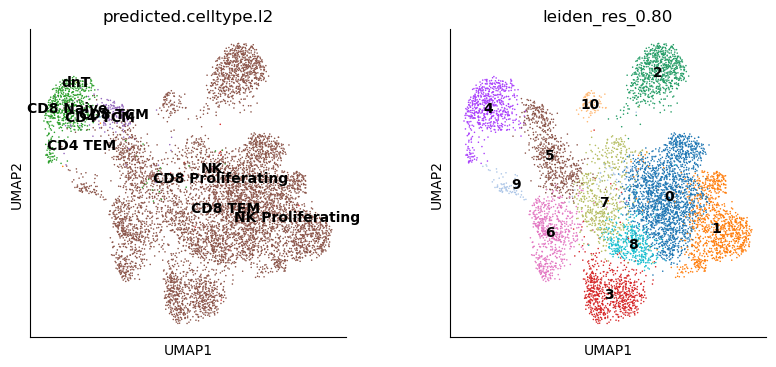

In [28]:
sc.pl.umap(adata_p116, color= ["predicted.celltype.l2","leiden_res_0.80"],legend_loc="on data", size=5)

In [29]:
adata_p116.obs["cell_type_lvl1"] = adata_p116.obs["leiden_res_0.80"].map(
    {
        "0": "Cytotoxic",
        "1": "Central memory",
        "2": "Naive",
        "3": "Activated effector",
        "4": "Activated inflammatory",
        "5": "Myeloid",
        "6": "Chronic inflammatory",
        "7": "Proliferating",
        "8": "Treg",

    }
)



In [30]:
adata_p116.obs["cell_type_lvl1"].value_counts()


cell_type_lvl1
Cytotoxic                 1970
Central memory            1011
Naive                      744
Activated effector         707
Activated inflammatory     629
Myeloid                    620
Chronic inflammatory       607
Proliferating              543
Treg                       413
Name: count, dtype: int64

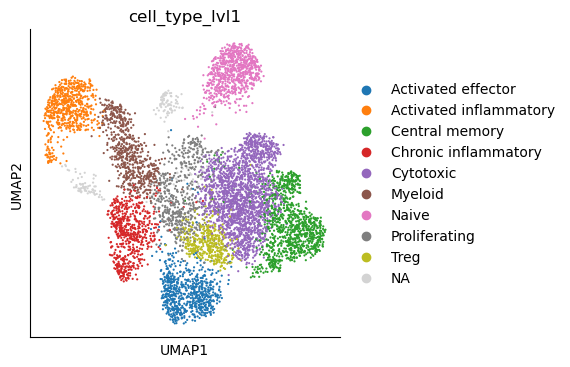

In [31]:
sc.pl.umap(adata_p116, color="cell_type_lvl1", size=10)

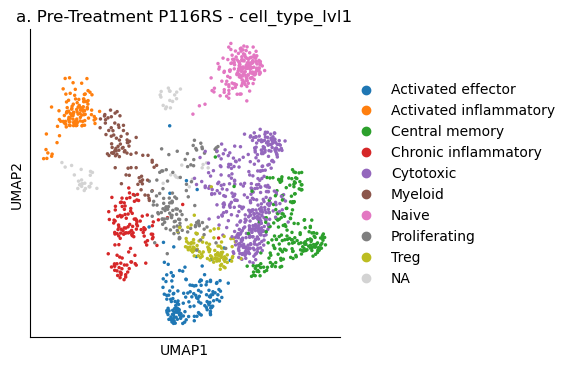

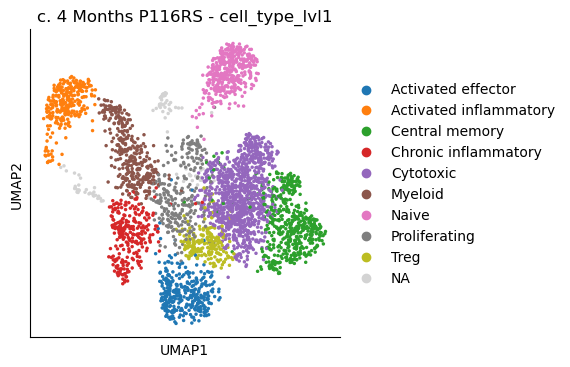

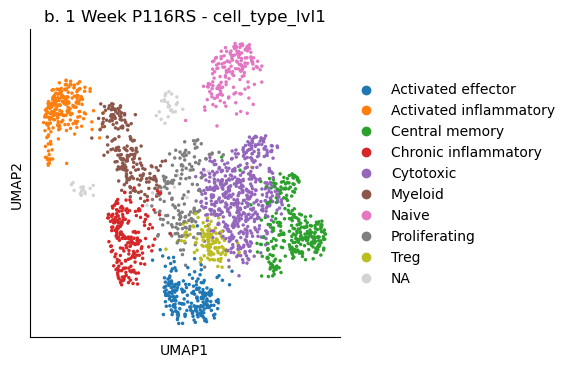

In [32]:
subsample_col = 'subsample'

# Itera sobre cada submuestra y genera un UMAP
for sample in adata_p116.obs[subsample_col].unique():
    adata_sub = adata_p116[adata_p116.obs[subsample_col] == sample]
    
    # Genera el UMAP coloreado por cell_type_lvl1
    sc.pl.umap(
        adata_sub,
        color="cell_type_lvl1",
        legend_loc='right margin',
        size=25,
        title=f"{sample} - cell_type_lvl1"
    )

# Code for Palantir

In [33]:
pca_embedding = pd.DataFrame(adata_p116.obsm["X_pca"], index=adata_p116.obs_names)
pca_embedding.shape

(7435, 50)

In [34]:
dm_res = palantir.utils.run_diffusion_maps(adata_p116, n_components=5)

computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:00)


In [35]:
ms_data = palantir.utils.determine_multiscale_space(dm_res)

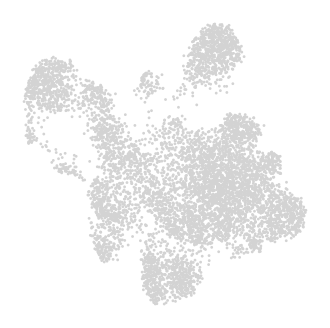

In [36]:
sc.pl.embedding(
    adata_p116,
    basis="umap",
    frameon=False,
)

In [37]:
imputed_X = palantir.utils.run_magic_imputation(adata_p116)

KeyboardInterrupt: 

In [ ]:
sc.pl.embedding(
    adata_p116,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CCR7", "LTB", "MKI67", "CD3D"],
    frameon=False,
)
plt.show()

In [ ]:
sc.pl.embedding(
    adata_p116,
    basis="umap",
    layer="MAGIC_imputed_data",
    color=["CD3D", "CD3E", "CD69", "CD8B","ITGAX","FCGR3A", "CD8A", "ITGAM", "KLRD1", "KLRC1", "KLRB1", "HAVCR2", "KLRF1", "TYROBP", "PDCD1", "CTLA4", "CCR7", "TCF7", "IL7R", "BCL2", "KLF2", "GZMB", "CX3CR1", "IL2RB", "TOX", "TIGIT", "TOP2A", "CXCR6", "ITGAE", "FGFBP2", "IL2RA", "PECAM1", "PMAIP1", "CSRNP1"],
    frameon=False,
)
plt.show()

In [ ]:
palantir.plot.plot_diffusion_components(adata_p116)
plt.show()

# Selecting first and last cells

In [ ]:
#Select only naïve CD4+ T cells 
cells_naive_pre= adata_p116.obs[
    (adata_p116.obs['predicted.celltype.l1'] == 'CD8 T') 
].index

#  naive markers
naive_markers = ["CCR7", "CD27", "SELL" ,"TCF7","LEF1", "IL7R"]  

naive_expr = adata_p116[cells_naive_pre, naive_markers].X

# If the matrix is sparse, convert to dense
if not isinstance(naive_expr, np.ndarray):
    naive_expr = naive_expr.toarray()

# Compute mean expression of the marker genes per cell
mean_naive_expr = np.mean(naive_expr, axis=1)

# Identify the single most naïve cell
root_cell = cells_naive_pre[np.argmax(mean_naive_expr)]
print(f"Selected root cell: {root_cell}")

In [ ]:
cell_id = "CIH003_reseq_TGGCGCAAGAAACCAT-1"

# is the cell there?
if cell_id not in adata_p116.obs_names:
    raise KeyError(f"La célula {cell_id} no está en adata_p116.obs_names")

# which cell type?
display(adata_p116.obs.loc[cell_id])

In [ ]:
cell_id = "CIH003_reseq_TGGCGCAAGAAACCAT-1"

# column for highlighting the cell
adata_p116.obs["__is_target"] = (adata_p116.obs_names == cell_id)

# Plot UMAP and color by that column
sc.pl.umap(adata_p116, color=["__is_target", "predicted.celltype.l2"], size=5, cmap="viridis", legend_loc=None)

# (optional) drop the temporary column afterwards
adata_p116.obs.drop(columns="__is_target", inplace=True)

In [ ]:
# Activated effector markers
cd8_cells = adata_p116.obs[
    adata_p116.obs['predicted.celltype.l1'] == 'CD8 T'
].index

# Markers
effector_markers = ["GZMB", "PRF1", "KLRG1", "CX3CR1", "TBX21"]

# Calcular expresión media de marcadores por célula
cd8_expr = adata_p116[cd8_cells][:, effector_markers].X.mean(axis=1)

# Obtener índice de la célula con mayor expresión de marcadores efectores
effector_terminal_cell = cd8_cells[np.argmax(cd8_expr)]

print(f"Selected effector terminal cell: {effector_terminal_cell}")


In [ ]:
terminal_states = pd.Series(
    ["Effector"],
    index=["CIH002_reseq_GGAAAGCCAATGAAAC-1"],
)

In [ ]:
cell_id = "CIH002_reseq_GGAAAGCCAATGAAAC-1"

# is the cell there?
if cell_id not in adata_p116.obs_names:
    raise KeyError(f"the cell {cell_id} is not in adata_p116.obs_names")

# which cell type?
display(adata_p116.obs.loc[cell_id])

In [ ]:
cell_id = "CIH002_reseq_GGAAAGCCAATGAAAC-1"

# column for highlighting the cell
adata_p116.obs["__is_target"] = (adata_p116.obs_names == cell_id)

# Plot UMAP and color by that column
sc.pl.umap(adata_p116, color=["__is_target", "predicted.celltype.l2"], size=5, cmap="viridis", legend_loc=None)

# (optional) drop the temporary column afterwards
adata_p116.obs.drop(columns="__is_target", inplace=True)

In [ ]:
palantir.plot.highlight_cells_on_umap(adata_p116, terminal_states)
plt.show()

In [ ]:
adata_p116.obsm['DM_EigenVectors_multiscaled'] = dm_res['EigenVectors'].values

In [ ]:
start_cell = "CIH003_reseq_TGGCGCAAGAAACCAT-1"
pr_res = palantir.core.run_palantir(
    adata_p116, start_cell, num_waypoints=500, terminal_states=terminal_states
)

In [ ]:
adata_p116.obs['pseudotime'] = pr_res.pseudotime.values

In [ ]:
palantir.plot.plot_palantir_results(adata_p116, s=3)
plt.show()

In [ ]:
cells = ["CIH003_reseq_TGGCGCAAGAAACCAT-1",
    "CIH003_reseq_TGGCGCAAGAAACCAT-1"
     
]
palantir.plot.plot_terminal_state_probs(adata_p116, cells)
plt.show()

In [ ]:
palantir.plot.highlight_cells_on_umap(adata_p116, cells)
plt.show()

In [ ]:
masks = palantir.presults.select_branch_cells(adata_p116, q=.01, eps=.01)

In [ ]:
palantir.plot.plot_branch_selection(adata_p116)
plt.show()

In [ ]:
palantir.plot.plot_trajectory(adata_p116, "Effector")

In [ ]:
palantir.plot.plot_trajectory(
    adata_p116, # your anndata
    "Effector", # the branch to plot
    cell_color="palantir_entropy", # the ad.obs colum to color the cells by
    n_arrows=10, # the number of arrow heads along the path
    color="red", # the color of the path and arrow heads
    scanpy_kwargs=dict(cmap="viridis"), # arguments passed to scanpy.pl.embedding
    arrowprops=dict(arrowstyle="->,head_length=.5,head_width=.5", lw=3), # appearance of the arrow heads
    lw=3, # thickness of the path
    pseudotime_interval=(0, .9), # interval of the pseudotime to cover with the path
)

In [ ]:
palantir.plot.plot_trajectories(adata_p116, pseudotime_interval=(0, .9))
# When using cell_color="branch_selection" be aware of the overlap between branches:
palantir.plot.plot_trajectories(adata_p116, cell_color = "branch_selection", pseudotime_interval=(0, .9))
plt.show()

In [ ]:
gene_trends = palantir.presults.compute_gene_trends(
    adata_p116,
    expression_key="MAGIC_imputed_data",
)

In [ ]:
#### Density curves (outline only)
##### Prepare branch-specific pseudotime from Palantir results #####
import numpy as np
import pandas as pd

pseudotime = pr_res.pseudotime
branch_probs = pr_res.branch_probs

# Align indices
branch_probs = branch_probs.loc[pseudotime.index]

# Branch-specific pseudotime
pt = branch_probs.multiply(pseudotime, axis=0)

# Optional filter by branch probability
prob_threshold = 0.02
pt = pt.where(branch_probs > prob_threshold)

##### Plotting branch-specific pseudotime and sample densities #####

import os
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import gaussian_kde

# --------------------------------------------------
# CONFIGURATION
# --------------------------------------------------
out_dir = "/lustre1/project/stg_00187/users/Cecilia/Data/5_Trajectory/v4/P116_CD8"
sl_name = "P116_CD8_palantir"
os.makedirs(out_dir, exist_ok=True)

embedding_key = "X_umap"
X = adata_p116.obsm[embedding_key]      
sample_labels = adata_p116.obs["subsample"]

branch_names = pt.columns

# Colormap and normalization
cmap = plt.get_cmap("viridis")
norm = Normalize(vmin=np.nanmin(pt.values), vmax=np.nanmax(pt.values))

# --------------------------------------------------
# LOOP OVER BRANCHES
# --------------------------------------------------
for i, branch in enumerate(branch_names, start=1):

    pt_branch = pt[branch].values

    if np.all(np.isnan(pt_branch)):
        print(f"Skipping branch {branch}: all NaN")
        continue

    fig, axes = plt.subplots(1, 2, figsize=(15, 7))
    ax_scatter, ax_density = axes

    # -------------------------------
    # LEFT PANEL: UMAP
    # -------------------------------
    colors = np.empty((len(pt_branch), 4))
    colors[:] = (0.9, 0.9, 0.9, 0.3)

    valid = ~np.isnan(pt_branch)
    colors[valid] = cmap(norm(pt_branch[valid]))

    ax_scatter.scatter(
        X[:, 0], X[:, 1],
        c=colors,
        s=8,
        linewidths=0
    )

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax_scatter)
    cbar.set_label("Branch-specific pseudotime", fontsize=12)

    ax_scatter.set_title(f"Pseudotime – Branch {branch}", fontsize=14)
    ax_scatter.set_xlabel("UMAP 1", fontsize=12)
    ax_scatter.set_ylabel("UMAP 2", fontsize=12)

    # -------------------------------
    # RIGHT PANEL: DENSITY (OUTLINE ONLY)
    # -------------------------------
    densities = {}
    x_min, x_max = np.inf, -np.inf
    y_max = 0

    for samp in sample_labels.unique():
        mask = (sample_labels == samp) & valid
        values = pt_branch[mask]

        if np.sum(mask) < 5:
            continue

        kde = gaussian_kde(values)
        xs = np.linspace(values.min(), values.max(), 200)
        ys = kde(xs)

        densities[samp] = (xs, ys)

        x_min = min(x_min, xs.min())
        x_max = max(x_max, xs.max())
        y_max = max(y_max, ys.max())

    if len(densities) > 0:
        ax_density.set_xlim(x_min, x_max)
        ax_density.set_ylim(0, y_max * 1.05)

        # *** OUTLINE ONLY ***
        for samp, (xs, ys) in densities.items():
            ax_density.plot(xs, ys, linewidth=2, label=samp)

    ax_density.set_xlabel("Pseudotime", fontsize=12)
    ax_density.set_ylabel("Density", fontsize=12)
    ax_density.set_title(f"Sample density on branch {branch}", fontsize=14)
    ax_density.legend(title="Sample", fontsize=9, title_fontsize=10)

    fig.suptitle(f"{sl_name} – Branch {branch}", fontsize=16)
    fig.tight_layout()

    # --------------------------------------------------
    # SAVE PDF
    # --------------------------------------------------
    out_file = os.path.join(out_dir, f"{sl_name}_branch_{i}.pdf")
    fig.savefig(out_file, bbox_inches="tight")
    plt.show(fig)
    plt.close(fig)

    print(f"Saved: {out_file}")


In [ ]:
genes = ["LTB", "TYROBP"]
palantir.plot.plot_gene_trends(adata_p116, genes)
plt.show()

In [ ]:
# Asegúrate de haber corrido este paso antes
sc.pp.highly_variable_genes(adata_p116, n_top_genes=10)

# Selecciona solo los genes marcados como altamente variables
top_genes = adata_p116.var[adata_p116.var['highly_variable']].index.tolist()

palantir.plot.plot_gene_trend_heatmaps(adata_p116, genes=top_genes)
plt.show()

# Genes on pseudotime from Effector branch

In [ ]:
# Definir célular citotóxicas por la branch
target_fate = "Effector"
threshold = 0.2

cells_cyto = pr_res.branch_probs.index[
    pr_res.branch_probs[target_fate] > threshold
]

# Extraer el pseudotime ya calculado para estas células
pseudotime_cyto = adata_p116.obs.loc[cells_cyto, 'pseudotime'].values

# Extraer expresión
X = adata_p116[cells_cyto, :].X
gene_names = adata_p116.var_names
X = pd.DataFrame(X, columns=gene_names, index=cells_cyto)

# Eliminar genes que sean todo ceros
genes_to_test = X.columns[X.sum(axis=0) > 0]



In [ ]:
pvals = []
r2_scores = []
smooth_values = []

# Convertir pseudotime a 2D para pygam
X_pt = pseudotime_cyto.reshape(-1, 1)

# Grid común para predicción (100 puntos equiespaciados)
grid = np.linspace(X_pt.min(), X_pt.max(), 100).reshape(-1, 1)

# Ajustar modelos GAM por gen
for gene in tqdm(genes_to_test, desc="Fitting GAMs"):
    y = X[gene].values
    model = GAM(s(0)).fit(X_pt, y)
    
    pvals.append(model.statistics_['p_values'][1])
    r2_scores.append(model.statistics_['pseudo_r2']['explained_deviance'])
    
    smooth = model.predict(grid)
    smooth_values.append(smooth)

In [ ]:
# Ajuste de p-valores
_, adj_pvals, _, _ = multipletests(pvals, method='fdr_bh')

# Guardar resultados
gam_results = pd.DataFrame({
    'gene': genes_to_test,
    'pval': pvals,
    'adj_pval': adj_pvals,
    'r2': r2_scores
}).set_index('gene')

# Filtrar por significancia (p.adj < 0.01)
significant_genes = gam_results[gam_results['adj_pval'] < 0.01].index.tolist()

# Expresiones suavizadas para genes significativos
smooth_matrix = np.array([smooth_values[i] for i, gene in enumerate(genes_to_test) if gene in significant_genes])


In [ ]:
# Manhattan distance
dist_mat = pdist(smooth_matrix, metric='cityblock')
linkage_mat = linkage(dist_mat, method='average')

# Asignar clústeres
clusters = fcluster(linkage_mat, t=6, criterion='maxclust')


In [ ]:
# Crear dataframe con anotaciones
heatmap_df = pd.DataFrame(smooth_matrix, index=significant_genes)
heatmap_df['cluster'] = clusters
heatmap_df = heatmap_df.sort_values('cluster')
heatmap_values = heatmap_df.drop(columns='cluster')

# Opcional: genes a anotar

label_genes = ["STAT1", "GATA1", "MPO", "IRF8"]
heatmap_values_filtered = heatmap_values.loc[heatmap_values.index.intersection(label_genes)]

# Generar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_values,
    cmap='viridis',       
    yticklabels=label_genes,     
    xticklabels=False
)

plt.xlabel("Pseudotime")
plt.ylabel("genes")
plt.tight_layout()
plt.show()


In [ ]:
smooth_df = pd.DataFrame(smooth_matrix, index=significant_genes)
smooth_df_scaled = pd.DataFrame(
    StandardScaler().fit_transform(smooth_df),
    index=smooth_df.index,
    columns=smooth_df.columns
)
top_n = 30  # Muestra los 30 más dinámicos

top_genes = gam_results.loc[significant_genes].sort_values('r2', ascending=False).head(top_n).index.tolist()
filtered_df = smooth_df.loc[top_genes]

sns.clustermap(
    filtered_df,
    cmap='viridis',
    col_cluster=False,
    figsize=(12, 8),
    yticklabels=True
)
plt.title(f"Top {top_n} pseudotime-dynamic genes (by R²)")
plt.show()

In [ ]:
adata_p116.obs['subsample'].value_counts()

In [ ]:
group_map = {
    "a. Pre-Treatment P116RS": "Pre-Treatment",
    "b. 1 Week P116RS": "1 Week After",
    "c. 4 Months P116RS": "4 Months After"}

In [ ]:
# Crear la columna treatment_group solo para las células citotóxicas
adata_p116.obs.loc[cells_cyto, 'treatment_group'] = adata_p116.obs.loc[cells_cyto, 'subsample'].map(group_map)

# Filtrar solo las células citotóxicas con grupo válido
filtered = adata_p116.obs.loc[cells_cyto].dropna(subset=['treatment_group']).copy()

# Usar el pseudotime ya calculado (pseudotime_cyto)
filtered['pseudotime_cyto'] = pseudotime_cyto[:len(filtered)]


group_means = filtered.groupby('treatment_group')['pseudotime_cyto'].mean()


print(group_means)


In [ ]:
# Definir pseudo_lin usando la grilla existente
pseudo_lin = grid

# Asignar a cada punto el grupo más cercano según pseudotime medio
group_labels = []
for pt in pseudo_lin:
    closest_group = group_means.index[np.argmin(np.abs(group_means.values - pt))]
    group_labels.append(closest_group)

In [ ]:
palette = {
    "Pre-Treatment": "#1f77b4",
    "1 Week After": "#ff7f0e",
    "4 Months After": "#2ca02c"
}
col_colors = pd.Series(group_labels, index=range(100)).map(palette)

In [ ]:
print(pd.Series(group_labels).value_counts())

In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(
    filtered_df,
    cmap='viridis',
    col_cluster=False,
    figsize=(12, 16),
    yticklabels=True,
    xticklabels=False,
    col_colors=col_colors
)

# Agregar leyenda para los time points (col_colors)
handles_col = [
    mpatches.Patch(color=color, label=label)
    for label, color in palette.items()
]
# Leyenda para columnas (time points)
g.ax_col_dendrogram.legend(
    handles=handles_col,
    loc="center",
    bbox_to_anchor=(0.5, 0.5),
    ncol=3,
    fontsize="medium"
)
cbar = g.cax
cbar.tick_params(labelsize=10)  
cbar.set_ylabel("Expression", fontsize=8, labelpad=10)  
cbar.set_aspect(1) 
plt.show()


# Regulons along pseudotime from effector branch

In [ ]:
# --- 1. Extraer los valores de AUC solo para las células citotóxicas ---
cells_mask = adata_p116.obs_names.isin(cells_cyto)

regulon_names = list(adata_p116.uns['Regulons_tuples'].dtype.names)
regulon_auc_df = pd.DataFrame(
    adata_p116.obsm['RegulonsAUC'][cells_mask, :],
    columns=regulon_names,
    index=adata_p116.obs_names[cells_mask]
)

# --- 2. Asegurar que los valores sean numéricos ---
regulon_auc_df = regulon_auc_df.apply(pd.to_numeric, errors='coerce').fillna(0)

# --- 3. Crear Series de pseudotime con el mismo índice ---
pseudotime_cyto = adata_p116.obs.loc[cells_cyto, "pseudotime"]
pseudotime_cyto = pd.Series(pseudotime_cyto.values, index=regulon_auc_df.index)

In [ ]:
gam_results = {}

for regulon in tqdm(regulon_auc_df.columns, desc="Fitting GAMs on regulons"):
    y = regulon_auc_df[regulon].values
    x = pseudotime_cyto.values.reshape(-1, 1)

    # Evitar errores por datos sin varianza o con NaNs
    if np.all(y == 0) or np.var(y) == 0 or np.isnan(y).any():
        continue

    gam = GAM(s(0, n_splines=5)).fit(x, y)
    y_pred = gam.predict(x)

    gam_results[regulon] = {
        'model': gam,
        'y_pred': y_pred,
        'y_var': np.var(y_pred),
        'auc_range': y_pred.max() - y_pred.min()
    }

print(f"Modelados {len(gam_results)} regulones con éxito.")


In [ ]:
# Crear una matriz de predicciones normalizadas
n_points = 100
pseudo_lin = np.linspace(pseudotime_cyto.min(), pseudotime_cyto.max())

smooth_df = pd.DataFrame()
for regulon, res in gam_results.items():
    y_smooth = res['model'].predict(pseudo_lin)
    smooth_df[regulon] = (y_smooth - np.mean(y_smooth)) / np.std(y_smooth)

smooth_df = smooth_df.T  # Transponer
smooth_df.index = list(gam_results.keys()) 

# Clustermap estilo Seurat heatmap
sns.clustermap(smooth_df, cmap='viridis', col_cluster=False, figsize=(12, 8))
plt.title("Regulon dynamics across pseudotime")
plt.show()

In [ ]:
"""regulons_to_plot = ['IRF1(+)', 'IRF4(+)', 'IRF7(+)','STAT1(+)']

# Identidad celular (usada para colorear los puntos)
cell_groups = cd4_adata.obs['predicted.celltype.l1']  # ajusta si se llama diferente

# Crear subplots
n_cols = 4
n_rows = int(np.ceil(len(regulons_to_plot) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 3), sharex=True)

for idx, regulon in enumerate(regulons_to_plot):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]

    x = pseudotime.values
    y = regulon_auc_df[regulon].values

    # Scatterplot por grupo
    groups = cell_groups.unique()
    for group in groups:
        mask = cell_groups == group
        ax.scatter(x[mask], y[mask], label=group, alpha=0.5, s=10)

    # GAM suavizado
    gam = GAM(s(0, n_splines=5)).fit(x.reshape(-1, 1), y)
    x_pred = np.linspace(x.min(), x.max(), 200)
    y_pred = gam.predict(x_pred)
    ax.plot(x_pred, y_pred, color='black')

    # Ejes y título
    ax.set_title(f"{regulon.replace('(+)', '')}-regulon", fontsize=10)
    ax.set_xlabel("Pseudotime")
    ax.set_ylabel("AUC")

# Ajustes finales
plt.tight_layout()
fig.legend(loc='lower center', ncol=len(groups), bbox_to_anchor=(0.5, -0.01))
plt.show()"""

In [ ]:
"""# Filtrar células deseadas
subset_mask = cd4_adata.obs['predicted.celltype.l2'].isin(['CD4 Naive', 'CD4 TCM'])
adata_subset = cd4_adata[subset_mask]

# Subconjuntos
pseudotime_subset = pseudotime[subset_mask]
regulon_auc_subset = regulon_auc_df.loc[subset_mask]
cell_groups_subset = adata_subset.obs['predicted.celltype.l2']  # para colorear"""

In [ ]:
group_map = {
    "a. Pre-Treatment P116RS": "Pre-Treatment",
    "b. 1 Week P116RS": "1 Week After",
    "c. 4 Months P116RS": "4 Months After"}


In [ ]:
# Crear columna de grupo de tratamiento para las células citotóxicas
adata_p116.obs.loc[cells_cyto, "treatment_group"] = (
    adata_p116.obs.loc[cells_cyto, "subsample"].map(group_map)
)

# Filtrar solo las células citotóxicas con tratamiento válido
filtered = adata_p116.obs.loc[
    adata_p116.obs_names.isin(cells_cyto) &
    adata_p116.obs["treatment_group"].notna(),
    ["treatment_group", "pseudotime"]
]

# Agrupar por grupo y obtener pseudotime promedio
group_means = filtered.groupby("treatment_group")["pseudotime"].mean()

print(group_means)



In [ ]:
# Para cada punto en pseudo_lin, asignar el grupo de tratamiento más cercano
group_labels = []
for pt in pseudo_lin:
    closest_group = group_means.index[np.argmin(np.abs(group_means.values - pt))]
    group_labels.append(closest_group)


In [ ]:
palette = {
    "Pre-Treatment": "#1f77b4",
    "1 Week After": "#ff7f0e",
    "4 Months After": "#2ca02c"
}
col_colors = pd.Series(group_labels, index=smooth_df.columns).map(palette)


In [ ]:
sns.clustermap(
    smooth_df,
    cmap='viridis',
    col_cluster=False,
    figsize=(12, 8),
    col_colors=col_colors
)
plt.title("Regulon dynamics across pseudotime with treatment groups")
plt.show()


# Genes on pseudotime recalculated on the effector branch only

In [ ]:
# defining the destiny of one branch
target_fate = "Effector"   
threshold = 0.2           

cells_cyto = pr_res.branch_probs.index[pr_res.branch_probs[target_fate] > threshold]
adata_cyto = adata_p116[cells_cyto, :].copy()  
terminal_cyto = terminal_states.loc[terminal_states == 'Effector']

In [ ]:
pr_res_cyto = palantir.core.run_palantir(
    adata_cyto,
    start_cell,
    terminal_states=terminal_cyto,
    num_waypoints=300
)

In [ ]:
adata_cyto.obs['pseudotime_cyto'] = pr_res_cyto.pseudotime.values

In [ ]:
X = adata_cyto.raw.X if adata_cyto.raw is not None else adata_cyto.X
gene_names = adata_cyto.raw.var_names if adata_cyto.raw is not None else adata_cyto.var_names
X = pd.DataFrame(X, columns=gene_names, index=adata_cyto.obs_names)

In [ ]:
genes_to_test = X.columns[X.sum(axis=0) > 0]
print(f"Genes a modelar: {len(genes_to_test)}")

In [ ]:
pvals = []
r2_scores = []
smooth_values = []

# Pseudotime 2D
X_pt = adata_cyto.obs["pseudotime_cyto"].values.reshape(-1, 1)
grid = np.linspace(X_pt.min(), X_pt.max(), 100).reshape(-1, 1)

for gene in tqdm(genes_to_test, desc="Fitting GAMs"):
    y = X[gene].values
    model = GAM(s(0)).fit(X_pt, y)
    
    pvals.append(model.statistics_['p_values'][1])
    r2_scores.append(model.statistics_['pseudo_r2']['explained_deviance'])
    
    smooth = model.predict(grid)
    smooth_values.append(smooth)

In [ ]:
# Ajuste de p-valores
_, adj_pvals, _, _ = multipletests(pvals, method='fdr_bh')

# Guardar resultados
gam_results = pd.DataFrame({
    'gene': genes_to_test,
    'pval': pvals,
    'adj_pval': adj_pvals,
    'r2': r2_scores
}).set_index('gene')

# Filtrar por significancia (p.adj < 0.01)
significant_genes = gam_results[gam_results['adj_pval'] < 0.01].index.tolist()

# Expresiones suavizadas para genes significativos
smooth_matrix = np.array([smooth_values[i] for i, gene in enumerate(genes_to_test) if gene in significant_genes])


In [ ]:
# Manhattan distance
dist_mat = pdist(smooth_matrix, metric='cityblock')
linkage_mat = linkage(dist_mat, method='average')

# Asignar clústeres
clusters = fcluster(linkage_mat, t=6, criterion='maxclust')


In [ ]:
# Crear dataframe con anotaciones
heatmap_df = pd.DataFrame(smooth_matrix, index=significant_genes)
heatmap_df['cluster'] = clusters
heatmap_df = heatmap_df.sort_values('cluster')
heatmap_values = heatmap_df.drop(columns='cluster')

# Opcional: genes a anotar

label_genes = ["STAT1", "GATA1", "MPO", "IRF8"]
heatmap_values_filtered = heatmap_values.loc[heatmap_values.index.intersection(label_genes)]

# Generar heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    heatmap_values,
    cmap='viridis',       
    yticklabels=label_genes,     
    xticklabels=False
)

plt.xlabel("Pseudotime")
plt.ylabel("genes")
plt.tight_layout()
plt.show()


In [ ]:
smooth_df = pd.DataFrame(smooth_matrix, index=significant_genes)
smooth_df_scaled = pd.DataFrame(
    StandardScaler().fit_transform(smooth_df),
    index=smooth_df.index,
    columns=smooth_df.columns
)
top_n = 30  # Muestra los 30 más dinámicos

top_genes = gam_results.loc[significant_genes].sort_values('r2', ascending=False).head(top_n).index.tolist()
filtered_df = smooth_df.loc[top_genes]

sns.clustermap(
    filtered_df,
    cmap='viridis',
    col_cluster=False,
    figsize=(12, 8),
    yticklabels=True
)
plt.title(f"Top {top_n} pseudotime-dynamic genes (by R²)")
plt.show()

In [ ]:
"STAT1" in adata_cyto.var_names

In [ ]:
group_map = {
    "a. Pre-Treatment P116RS": "Pre-Treatment",
    "b. 1 Week P116RS": "1 Week After",
    "c. 4 Months P116RS": "4 Months After"}

In [ ]:
# Crear una columna con la fase del tratamiento
adata_cyto.obs['treatment_group'] = adata_cyto.obs['subsample'].map(group_map)

# Quitar células que no están en el mapeo
filtered = adata_cyto.obs.dropna(subset=['treatment_group'])

# Agrupar por grupo y obtener el pseudotime promedio
group_means = filtered.groupby('treatment_group')['pseudotime_cyto'].mean()
print(group_means)

In [ ]:
# Definir pseudo_lin usando la grilla existente
pseudo_lin = grid

# Asignar a cada punto el grupo más cercano según pseudotime medio
group_labels = []
for pt in pseudo_lin:
    closest_group = group_means.index[np.argmin(np.abs(group_means.values - pt))]
    group_labels.append(closest_group)

In [ ]:
palette = {
    "Pre-Treatment": "#1f77b4",    # azul
    "1 Week After": "#ff7f0e",  # naranja
    "4 Months After": "#2ca02c"    # verde
}

In [ ]:
col_colors = pd.Series(group_labels, index=range(100)).map(palette)

In [ ]:
print(pd.Series(group_labels).value_counts())

In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(
    filtered_df,
    cmap='viridis',
    col_cluster=False,
    figsize=(12, 10),
    yticklabels=True,
    xticklabels=False,
    col_colors=col_colors
)

# Agregar leyenda para los time points (col_colors)
handles_col = [
    mpatches.Patch(color=color, label=label)
    for label, color in palette.items()
]
# Leyenda para columnas (time points)
g.ax_col_dendrogram.legend(
    handles=handles_col,
    loc="center",
    bbox_to_anchor=(0.5, 0.5),
    ncol=3,
    fontsize="medium"
)
cbar = g.cax
cbar.tick_params(labelsize=10)  
cbar.set_ylabel("Expression", fontsize=10, labelpad=10)  
cbar.set_aspect(1) 
plt.show()

# Regulons AUC on pseudotime

In [ ]:
regulons_array = adata.uns['Regulons_tuples']
print(regulons_array.dtype)

In [ ]:
regulon_auc = adata_cyto.obsm['RegulonsAUC']  # shape: cells x regulons
regulon_names = list(adata_cyto.uns['Regulons_tuples'].dtype.names)
regulon_auc_df = pd.DataFrame(regulon_auc, columns=regulon_names, index=adata_cyto.obs_names)
pseudotime = adata_cyto.obs['pseudotime_cyto']


In [ ]:
# Crear DataFrame con nombres de regulones
regulon_names = list(adata_cyto.uns['Regulons_tuples'].dtype.names)
regulon_auc_df = pd.DataFrame(adata_cyto.obsm['RegulonsAUC'], columns=regulon_names, index=adata_cyto.obs_names)

# Asegurar que los valores sean numéricos
regulon_auc_df = regulon_auc_df.apply(pd.to_numeric, errors='coerce')

# Rellenar NaNs con 0 para evitar errores en np.isnan
regulon_auc_df = regulon_auc_df.fillna(0)


In [ ]:
from pygam import GAM, s

# Para cada regulón
gam_results = {}
for regulon in regulon_auc_df.columns:
    y = regulon_auc_df[regulon].values
    x = pseudotime.values.reshape(-1, 1)

    if y.sum() == 0 or np.isnan(y).any():
        continue

    gam = GAM(s(0, n_splines=5)).fit(x, y)
    y_pred = gam.predict(x)

    gam_results[regulon] = {
        'model': gam,
        'y_pred': y_pred,
        'y_var': np.var(y_pred),
        'auc_range': y_pred.max() - y_pred.min()
    }


In [ ]:
# Crear una matriz de predicciones normalizadas
n_points = 100
pseudo_lin = np.linspace(pseudotime.min(), pseudotime.max())

smooth_df = pd.DataFrame()
for regulon, res in gam_results.items():
    y_smooth = res['model'].predict(pseudo_lin)
    smooth_df[regulon] = (y_smooth - np.mean(y_smooth)) / np.std(y_smooth)

smooth_df = smooth_df.T  # Transponer
smooth_df.index = list(gam_results.keys()) 

# Clustermap estilo Seurat heatmap
sns.clustermap(smooth_df, cmap='viridis', col_cluster=False, figsize=(12, 8))
plt.title("Regulon dynamics across pseudotime")
plt.show()

# Regulons on pseudotime by time point

In [ ]:
group_map = {
    "a. Pre-Treatment P116RS": "Pre-Treatment",
    "b. 1 Week P116RS": "1 Week After",
    "c. 4 Months P116RS": "4 Months After"}

In [ ]:
print(adata_cyto.obs['subsample'].unique())
print(group_map.keys())

In [ ]:
# Crear una columna con la fase del tratamiento
adata_cyto.obs['treatment_group'] = adata_cyto.obs['subsample'].map(group_map)

# Quitar células que no están en el mapeo
filtered = adata_cyto.obs.dropna(subset=['treatment_group'])

# Agrupar por grupo y obtener el pseudotime promedio
group_means = filtered.groupby('treatment_group')['pseudotime_cyto'].mean()
print(group_means)


In [ ]:
# Para cada punto en pseudo_lin, asignar el grupo de tratamiento más cercano
group_labels = []
for pt in pseudo_lin:
    closest_group = group_means.index[np.argmin(np.abs(group_means.values - pt))]
    group_labels.append(closest_group)


In [ ]:
palette = {
    "Pre-Treatment": "#1f77b4",
    "1 Week After": "#ff7f0e",
    "4 Months After": "#2ca02c"
}
col_colors = pd.Series(group_labels, index=smooth_df.columns).map(palette)


In [ ]:
import matplotlib.patches as mpatches
g = sns.clustermap(
    smooth_df,
    cmap='viridis',
    col_cluster=False,
    figsize=(12, 8),
    xticklabels=False,
    col_colors=col_colors
)

# Agregar leyenda para los time points (col_colors)
handles_col = [
    mpatches.Patch(color=color, label=label)
    for label, color in palette.items()
]
# Leyenda para columnas (time points)
g.ax_col_dendrogram.legend(
    handles=handles_col,
    loc="center",
    bbox_to_anchor=(0.5, 0.5),
    ncol=3,
    fontsize="medium"
)
cbar = g.cax
cbar.tick_params(labelsize=10)  
cbar.set_ylabel("Expression", fontsize=10, labelpad=10)  
cbar.set_aspect(1) 
plt.show()

# Complete analysis of regulons

In [ ]:
# ---------------------------------------------
# 🔹 Variables iniciales
# ---------------------------------------------
pvals = []
r2_scores = []
smooth_values = []
regulons_to_test = regulon_auc_df.columns

# Convertir pseudotime a 2D para pygam
X_pt = pseudotime.values.reshape(-1, 1)

# Grid común para predicción (100 puntos equiespaciados)
grid = np.linspace(X_pt.min(), X_pt.max(), 100).reshape(-1, 1)

# ---------------------------------------------
# 🔹 Ajustar modelos GAM por regulón
# ---------------------------------------------
for regulon in tqdm(regulons_to_test, desc="Fitting GAMs on regulons"):
    y = regulon_auc_df[regulon].values

    # Evitar regulones sin varianza o con NaNs
    if np.all(y == 0) or np.var(y) == 0 or np.isnan(y).any():
        pvals.append(np.nan)
        r2_scores.append(np.nan)
        smooth_values.append(np.zeros(len(grid)))
        continue

    model = GAM(s(0)).fit(X_pt, y)

    # Guardar estadísticas
    pvals.append(model.statistics_['p_values'][1])
    r2_scores.append(model.statistics_['pseudo_r2']['explained_deviance'])

    # Predicción suavizada
    smooth = model.predict(grid)
    smooth_values.append(smooth)

# ---------------------------------------------
# 🔹 Corrección por FDR
# ---------------------------------------------
_, adj_pvals, _, _ = multipletests(
    [p for p in pvals if not np.isnan(p)],
    method='fdr_bh'
)

regulon_gam_results = pd.DataFrame({
    'regulon': regulons_to_test,
    'pval': pvals,
    'adj_pval': adj_pvals,
    'r2': r2_scores
}).set_index('regulon')

# Filtrar por significancia (p.adj < 0.01)
significant_regulons = regulon_gam_results[
    regulon_gam_results['adj_pval'] < 0.01
].index.tolist()

print(f"✅ {len(significant_regulons)} regulones significativos (adj_p < 0.01)")

# ---------------------------------------------
# 🔹 Clustering jerárquico por dinámica suavizada
# ---------------------------------------------
smooth_matrix = np.array([
    smooth_values[i] for i, r in enumerate(regulons_to_test)
    if r in significant_regulons
])

# Calcular distancias Manhattan y clustering
if len(significant_regulons) > 1:
    dist_mat = pdist(smooth_matrix, metric='cityblock')
    linkage_mat = linkage(dist_mat, method='average')
    clusters = fcluster(linkage_mat, t=6, criterion='maxclust')
    regulon_gam_results.loc[significant_regulons, 'cluster'] = clusters
else:
    linkage_mat, clusters = None, None




In [ ]:
smooth_df_auc = pd.DataFrame(smooth_matrix, index=significant_regulons)

smooth_df__auc_scaled = pd.DataFrame(
    StandardScaler().fit_transform(smooth_df_auc),
    index=smooth_df_auc.index,
    columns=smooth_df_auc.columns
)

top_n = 30
top_regulons = (
    regulon_gam_results
    .loc[significant_regulons]
    .sort_values('r2', ascending=False)
    .head(top_n)
    .index.tolist()
)
filtered_df_auc = smooth_df__auc_scaled.loc[top_regulons]

sns.clustermap(
    filtered_df_auc,
    cmap='viridis',
    col_cluster=False,
    figsize=(12, 8),
    yticklabels=True
)
plt.title(f"Top {top_n} pseudotime-dynamic AUC (by R²)")
plt.show()

In [ ]:
print(closest_group)

In [ ]:
n_points = 100
pseudo_lin = np.linspace(pseudotime_cyto.min(), pseudotime_cyto.max(), n_points)
group_labels = []

for pt in pseudo_lin:
    closest_group = group_means.index[np.argmin(np.abs(group_means.values - pt))]
    group_labels.append(closest_group)
    
group_map = {
    "a. Pre-Treatment P116RS": "Pre-Treatment",
    "b. 1 Week P116RS": "1 Week After",
    "c. 4 Months P116RS": "4 Months After"}

adata_cyto.obs["treatment_group"] = adata_cyto.obs["subsample"].map(group_map)

# Promedio de pseudotime por grupo
group_means = adata_cyto.obs.groupby("treatment_group")["pseudotime_cyto"].mean().sort_values()
print(group_means)

# Asignar grupo más cercano a cada punto del pseudotime lineal
group_labels = []
for pt in pseudo_lin.flatten():
    closest_group = group_means.index[np.argmin(np.abs(group_means.values - pt))]
    group_labels.append(closest_group)

# Colores para cada grupo
palette = {
    "Pre-Treatment": "#1f77b4",
    "1 Week After": "#ff7f0e",
    "4 Months After": "#2ca02c"
}
col_colors = [palette[g] for g in group_labels]

# -----------------------------------------------------------
# 🔹 Clustermap final con colores por tratamiento
# -----------------------------------------------------------
sns.clustermap(
    filtered_df_auc,
    cmap="viridis",
    col_cluster=False,  # mantiene el orden temporal
    figsize=(12, 8),
    col_colors=col_colors,
    yticklabels=True
)

plt.title(f"Top {top_n} regulons dynamics across pseudotime with treatment groups")
plt.xlabel("Pseudotime")
plt.ylabel("Regulons")
plt.show()

# Regulons one by one

In [ ]:
# Filtrar células deseadas
subset_mask = adata_cyto.obs['predicted.celltype.l2'].isin(['CD8 Naive', 'CD8 TCM']) # elegir las que se quiera visualizar
adata_subset = adata_cyto[subset_mask]

# Subconjuntos
pseudotime_subset = pseudotime_cyto[subset_mask]
regulon_auc_subset = regulon_auc_df.loc[subset_mask]
cell_groups_subset = adata_subset.obs['predicted.celltype.l2']  # para colorear

In [ ]:
regulons_to_plot = ['IRF1(+)', 'IRF4(+)', 'XBP1(+)', 'STAT1(+)', 'EGR1(+)', 'JUNB(+)']

# Configuración de subplots
n_cols = 3
n_rows = int(np.ceil(len(regulons_to_plot) / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), sharex=True)

for idx, regulon in enumerate(regulons_to_plot):
    row, col = divmod(idx, n_cols)
    ax = axes[row, col] if n_rows > 1 else axes[col]

    x = pseudotime_subset.values
    y = regulon_auc_subset[regulon].values

    # Scatterplot por grupo celular
    for group in ['CD8 Naive', 'CD8 TCM']: # cambiar segun 
        mask = cell_groups_subset == group
        ax.scatter(x[mask], y[mask], label=group, alpha=0.5, s=10)

    # GAM fit
    gam = GAM(s(0, n_splines=5)).fit(x.reshape(-1, 1), y)
    x_pred = np.linspace(x.min(), x.max(), 200)
    y_pred = gam.predict(x_pred)
    ax.plot(x_pred, y_pred, color='black')

    ax.set_title(f"{regulon.replace('(+)', '')}-regulon")
    ax.set_xlabel("Pseudotime")
    ax.set_ylabel("AUC")

plt.tight_layout()
plt.legend(loc='lower center', bbox_to_anchor=(0.5, -0.01), ncol=2)
plt.show()
